<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Случайный-лес" data-toc-modified-id="Случайный-лес-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Случайный лес</a></span></li><li><span><a href="#Логистическая-регрессия" data-toc-modified-id="Логистическая-регрессия-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Логистическая регрессия</a></span></li><li><span><a href="#LightGBM" data-toc-modified-id="LightGBM-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li>

# Проект для «Викишоп» c BERT

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Необходимо обучть модель классифицировать комментарии на позитивные и негативные. Предоставлен набор данных с разметкой о токсичности правок.

Требуется построить модель со значением метрики качества *F1* не меньше 0.75. 

**Порядок выполения проекта**

1. Загрузить и подготовьть данные.
2. Обучить разные модели. 
3. Сделайть выводы.

## Подготовка

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import matplotlib.pyplot as plt
import torch
import transformers
import re
from tqdm import notebook
from joblib import Parallel, delayed

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier 
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.over_sampling import SMOTE



In [7]:
path = 'datasets/toxic_comments.csv'
if os.path.exists(path):
    data = pd.read_csv(path, index_col=0)
else:
    print('Что-то пошло не так')

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


In [9]:
data.sample(5, random_state=12345)

,text,toxic
Unnamed: 0,,
109583,Expert Categorizers \n\nWhy is there no menti...,0
105077,"""\n\n Noise \n\nfart* talk. """,1
82244,"An indefinite block is appropriate, even for a...",0
18740,I don't understand why we have a screenshot of...,0
128310,"Hello! Some of the people, places or things yo...",0


In [10]:
data.isna().sum().sum()

0

In [11]:
data.duplicated().sum()

0

In [12]:
def clear_text(text):
    new_text = re.sub(r'[^a-zA-Z ]', ' ', text) 
    return " ".join(new_text.split())

In [13]:
notebook.tqdm.pandas()
data['cleared_text'] = data['text'].progress_apply(clear_text) #очистка текстов

  0%|          | 0/159292 [00:00<?, ?it/s]

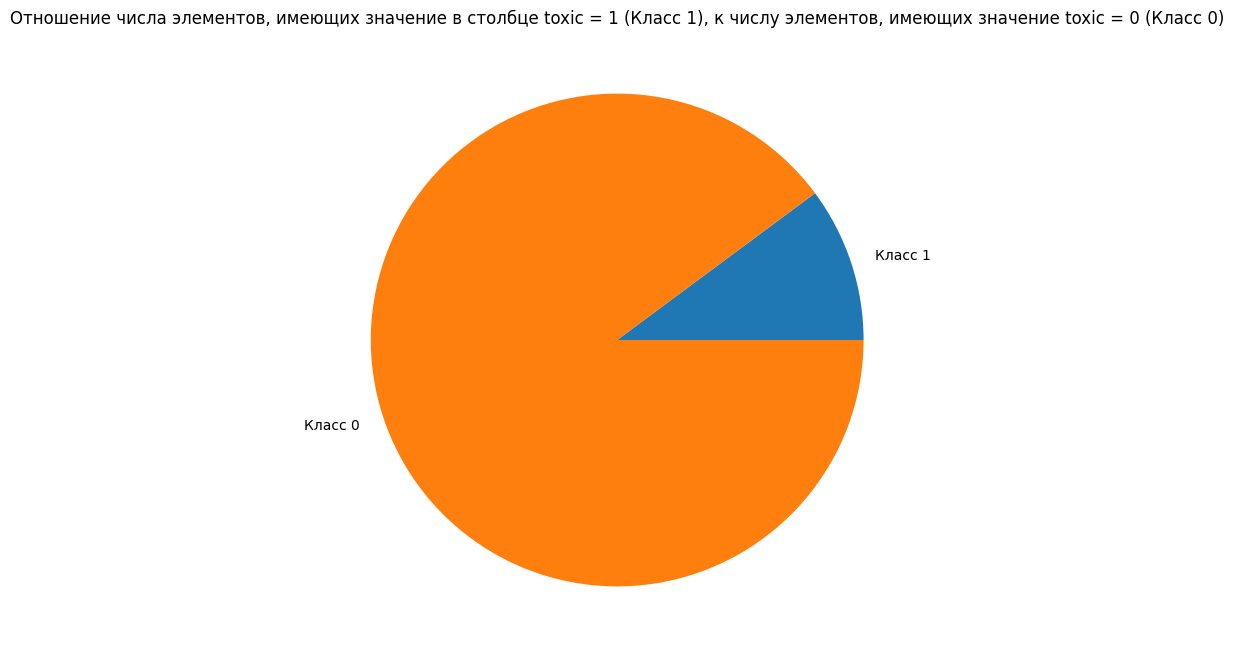

In [14]:

fig = plt.figure(figsize=(8, 8))
plt.title('Отношение числа элементов, имеющих значение в столбце toxic = 1 (Класс 1), \
к числу элементов, имеющих значение toxic = 0 (Класс 0)')
plt.pie([len(data.loc[data['toxic'] != 0, 'toxic']), len(data.loc[data['toxic'] == 0, 'toxic'])],
        labels=['Класс 1','Класс 0']);

In [15]:
data_sample = data.sample(2400, random_state=12345).reset_index(drop=True)# берем sample 2400 строк

In [16]:
tokenizer = transformers.BertTokenizer.from_pretrained('unitary/toxic-bert', HF_HUB_DISABLE_SYMLINKS_WARNING = True) #  обученый токенизатор для BERT

In [17]:
tokenized = data_sample['cleared_text'].apply( # применяем токенизатор, ограничивая число токенов и укорачивая слишком длинный текст
    lambda x: tokenizer.encode(x, truncation=True, add_special_tokens=True, max_length=512))

In [18]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)# Пусть стандартной длиной векторов будет длина наибольшего во всём датасете вектора.

padded = np.array([i + [0]*(max_len - len(i)) for i in tokenized.values])

attention_mask = np.where(padded != 0, 1, 0) #укажем нулевые и не нулевые значения токенов для вектора внимания

In [19]:
model = transformers.BertModel.from_pretrained('unitary/toxic-bert')#bert-base-uncased 

In [20]:
def batch_embedding(i, batch_size, attention_mask, model):
    batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) # преобразуем данные в формат тензоров
    attention_mask_batch = torch.LongTensor(attention_mask[batch_size*i:batch_size*(i+1)])
        
    with torch.no_grad():
        batch_embeddings = model(batch, attention_mask=attention_mask_batch) #эмбеддинги для батча
        
    return batch_embeddings[0][:,0,:].numpy()
    
    

In [21]:

batch_size = 32 # размер батча
embeddings = Parallel(n_jobs=6)(delayed(batch_embedding)(i, batch_size, attention_mask, model) 
                                for i in notebook.tqdm(range(padded.shape[0] // batch_size)))#список для хранения эмбеддингов    
 


  0%|          | 0/75 [00:00<?, ?it/s]

In [22]:
features = np.concatenate(embeddings)
target = data_sample['toxic']

In [23]:
features_train_valid, features_test, target_train_valid, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345, stratify=target)# отделяем 80% данных для обучающей и валидацианной выборки


In [24]:
features_train_valid.shape

(1920, 768)

1. Удален столбец `Unnamed: 0`, поскольку он не нужен для обучения моделей.
2. Получена выборка из 2400 строк таблицы.
3. Очистили тексты и создали признаки с помощью модели BERT.
4. Разделили данные на выборки для обучения, валидации и тестирования.

## Обучение

### Случайный лес

In [25]:
imba_pipeline = make_pipeline(SMOTE(random_state=12345), # для обучения на сбалансированных данных
                              RandomForestClassifier(random_state=12345))# cоздаем конвеер
params = {'max_depth':range(10, 20, 2), 'n_estimators':range(120, 200, 10)}
new_params = {'randomforestclassifier__' + key: params[key] for key in params}

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=
                         StratifiedKFold(4, shuffle=True, random_state=12345), scoring='f1', n_jobs=-1)

In [26]:
%%time
grid_imba.fit(features_train_valid, target_train_valid)

CPU times: total: 9.73 s
Wall time: 2min 36s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=12345)),
                                       ('randomforestclassifier',
                                        RandomForestClassifier(random_state=12345))]),
             n_jobs=-1,
             param_grid={'randomforestclassifier__max_depth': range(10, 20, 2),
                         'randomforestclassifier__n_estimators': range(120, 200, 10)},
             scoring='f1')

In [27]:
best_forest = grid_imba.best_estimator_.named_steps['randomforestclassifier']# лучший лес
best_forest

RandomForestClassifier(max_depth=12, n_estimators=130, random_state=12345)

In [28]:
score_forest = grid_imba.best_score_
print('Значение f1 для лучших параметров случайного леса на валидационных данных:', score_forest)

Значение f1 для лучших параметров случайного леса на валидационных данных: 0.9274464875619357


### Логистическая регрессия

In [29]:
imba_pipeline = make_pipeline(SMOTE(random_state=12345), 
                              LogisticRegression(max_iter=1000, random_state=12345))
params = {'solver':['lbfgs', 'liblinear']}
new_params = {'logisticregression__' + key: params[key] for key in params}

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=
                         StratifiedKFold(4, shuffle=True, random_state=12345), scoring='f1', n_jobs=-1)

In [30]:
%%time
grid_imba.fit(features_train_valid, target_train_valid)


CPU times: total: 453 ms
Wall time: 2.36 s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=12345)),
                                       ('logisticregression',
                                        LogisticRegression(max_iter=1000,
                                                           random_state=12345))]),
             n_jobs=-1,
             param_grid={'logisticregression__solver': ['lbfgs', 'liblinear']},
             scoring='f1')

In [31]:
best_lr = grid_imba.best_estimator_.named_steps['logisticregression']# лучшая регрессия
best_lr

LogisticRegression(max_iter=1000, random_state=12345, solver='liblinear')

In [32]:
score_lr = grid_imba.best_score_
print('Значение f1 для лучших параметров линейной регрессии на валидационных данных:', score_lr)

Значение f1 для лучших параметров линейной регрессии на валидационных данных: 0.9066484070263621


### LightGBM

In [61]:
imba_pipeline = make_pipeline(SMOTE(random_state=12345), 
                              LGBMClassifier(random_state=12345))
params = {'max_depth':range(10, 20, 2), 'n_estimators':range(120, 200, 10), 'num_leaves':range(20, 51, 10)}
new_params = {'lgbmclassifier__' + key: params[key] for key in params}

grid_imba = GridSearchCV(imba_pipeline, param_grid=new_params, cv=
                         StratifiedKFold(4, shuffle=True, random_state=12345), scoring='f1', n_jobs=6)

In [62]:
%%time
grid_imba.fit(features_train_valid, target_train_valid)

[LightGBM] [Info] Number of positive: 1710, number of negative: 1710
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026820 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 195840
[LightGBM] [Info] Number of data points in the train set: 3420, number of used features: 768
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
CPU times: total: 30 s
Wall time: 35min 27s


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=12345, shuffle=True),
             estimator=Pipeline(steps=[('smote', SMOTE(random_state=12345)),
                                       ('lgbmclassifier',
                                        LGBMClassifier(random_state=12345))]),
             n_jobs=6,
             param_grid={'lgbmclassifier__max_depth': range(10, 20, 2),
                         'lgbmclassifier__n_estimators': range(120, 200, 10),
                         'lgbmclassifier__num_leaves': range(20, 51, 10)},
             scoring='f1')

In [63]:
best_LGBM = grid_imba.best_estimator_.named_steps['lgbmclassifier']
best_LGBM

LGBMClassifier(max_depth=12, n_estimators=120, num_leaves=30,
               random_state=12345)

In [64]:
score_LGBM = grid_imba.best_score_
print('Значение f1 для лучших параметров LightGBM на валидационных данных:', score_LGBM)

Значение f1 для лучших параметров LightGBM на валидационных данных: 0.933943243088691


In [65]:
model_compare= pd.DataFrame({'Название модели':['RandomForestClassifier', 'LogisticRegression', 'LGBMClassifier'],
                           'Значение f1': [score_forest, score_lr, score_LGBM]})

model_compare.sort_values(by=['Значение f1'], ascending=False).reset_index(drop=True).style.background_gradient(cmap='Reds')

,Название модели,Значение f1
0,LGBMClassifier,0.933943
1,RandomForestClassifier,0.927446
2,LogisticRegression,0.906648


## Тестирование

In [66]:
test_prediction = best_LGBM.predict(features_test)
best_model_score = f1_score(target_test, test_prediction)
print('Значение f1 для лучшей модели на тестовых данных:', best_model_score)

Значение f1 для лучшей модели на тестовых данных: 0.9142857142857143


In [67]:
model = DummyClassifier(strategy='stratified', random_state=12345)

model.fit(features_train_valid, target_train_valid)

predicted_test = model.predict(features_test)
dummy_model_score = f1_score(target_test, predicted_test)
print('Значение f1 для DummyRegressor на тестовых данных:', dummy_model_score)

Значение f1 для DummyRegressor на тестовых данных: 0.1568627450980392


Лучшая модель дает значение f1 > 0.75 на тестовых данных, поэтому можно сделать вывод, что неплохо соблюдается баланс значений метрик Precision и Recall. Значение f1 для DummyClassifier меньше, чем для лучшей модели, это показывает адекватность модели.

## Выводы

Сделали сбалансированную выборку из 2400 строк, создали признаки с помощью модели BERT.
Быстрее всего обучилась модель LogisticRegression (DummyClassifier не учитываем) и дала самое маленькое значение f1 на валидационных данных. Модель RandomForest дала меньшее значение f1 для валидационных данных, чем LightGBM, обучалась и делала предсказания почти в 4 раз быстрее. LightGBM дала наибольшее значение f1 для валидационных данных, было показано, что эта модель адекватна и дает на тестовых данных f1 > 75, поэтому можно сделать вывод, что неплохо соблюдается баланс значений метрик Precision и Recall. 

(Recall используется для оценки доли ложно-отрицательных значений предсказания, если бы нам было нужно найти как можно больше токсичных комментариев, нужно было бы использовать эту метрику. Для максимизации Precision функция ошибок должна определять все положительные предсказания как истинно-положительное, для максимизации Recall функция ошибок должна определять все отрицательные предсказания как истинно-отрицательные. Если два условия, указанные выше, одновременно выполняются, то будет максимизация значения f1.)  